## Build a `Langgraph` with `llm`, `tool calling` and `binding`

In [78]:
from typing import TypedDict, Annotated, Any

from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, AIMessage, HumanMessage, AnyMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.tools import tool
from langchain_tavily import TavilySearch

from langgraph.graph import START, END, StateGraph, add_messages
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

from IPython.display import display, Image

from dotenv import load_dotenv

In [2]:
load_dotenv()

True

#### Model

In [37]:
llm = ChatOpenAI(model="gpt-4o")

#### State

In [41]:
class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

#### Tools

In [64]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

def add(a: int, b: int) -> int:
    """Add a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def sub(a: int, b: int) -> int:
    """Subtract b from a.

    Args:
        a: first int
        b: second int
    """
    return a - b

def div(a: int, b: int) -> int:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a // b


In [65]:
'''
It wraps your base LLM (ChatOpenAI in this case) and gives it structured awareness of the tools (functions) you provide — so the model can:
1) Know which tools exist (name, docstring, parameters)
2) Know how to call them using structured JSON arguments
3) Produce tool call requests instead of just text
Important: It Does Not Execute the Tool
'''
llm_with_tools = llm.bind_tools([multiply, add, sub, div])

In [66]:
'''
When you call llm_with_tools.invoke(...), the LLM decides whether to call a tool or not — but it does not automatically execute the tool.
'''
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [72]:
# Use built-in ToolNode to handle execution of the tool calls
'''
ToolNode is a prebuilt LangGraph component that automatically:
1) Listens for tool call requests emitted by your LLM
2) Executes those tool functions with the provided arguments
3) Returns the results back to the graph as messages
'''
tool_node = ToolNode(tools=[multiply, add, sub, div])

#### Build graph

In [79]:
graph = StateGraph(MessagesState)
graph.add_node("tool_calling_llm", tool_calling_llm)
graph.add_node("tools", tool_node)

graph.add_edge(START, "tool_calling_llm")
graph.add_edge("tool_calling_llm", "tools")
graph.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
graph.add_edge("tools", END)
app = graph.compile()

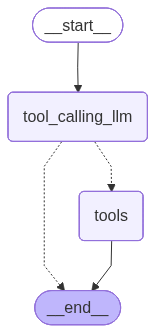

In [80]:
display(Image(app.get_graph().draw_mermaid_png()))

In [81]:
result1 = app.invoke({"messages": HumanMessage(content="multiply 8 and 2")})

In [82]:
for m in result1['messages']:
    m.pretty_print()

================================ Human Message =================================

multiply 8 and 2
================================== Ai Message ==================================
Tool Calls:
  multiply (call_IpTcdKNRNhVhXDKkvnZdUq3P)
 Call ID: call_IpTcdKNRNhVhXDKkvnZdUq3P
  Args:
    a: 8
    b: 2
================================= Tool Message =================================
Name: multiply

16


In [83]:
result2 = app.invoke({"messages": HumanMessage(content="what is the total population of India?")})

for m in result2['messages']:
    m.pretty_print()

================================ Human Message =================================

what is the total population of India?
================================== Ai Message ==================================

As of October 2021, India's estimated population was about 1.39 billion people. However, for the most current population data, please refer to the latest statistics from reliable sources such as the United Nations or the World Bank.
